A decision tree is a supervised learning algorithm used for classification and regression tasks. It is a flowchart-like structure where each internal node represents a feature (or attribute), each branch represents a decision rule, and each leaf node represents an outcome (a class label for classification or a value for regression).

In a medical context, a decision tree can decide if a patient has a disease based on symptoms (e.g., fever, cough, fatigue). Each node represents a question (e.g., "Does the patient have a fever?"), and the leaf node indicates the diagnosis.

## Importing Libraries

In [1]:
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Computes the Gini Impurity, a metric for determining the purity of a split.

In [2]:
def giniImpurity(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return np.sum(ps * (1 - ps))

In [3]:
# test giniIndex

y = [2, 1, 1, 1, 1, 1]
print(giniImpurity(y))

0.2777777777777778


Node class: Represents a single node in the decision tree.

In [4]:
class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

DecisionTree Class:
* Minimum number of samples required to split a node.
* max_depth: Maximum depth of the tree.
* n_feats: Number of features to consider when splitting (used for Random Forest).
* root: The root node of the tree.

In [5]:
class DecisionTree(BaseEstimator):

    def __init__(self, min_samples_split=5, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats # for random forest, choosing a subset of features
        self.root = None

    #Initiates the recursive process of growing the decision tree from the root using
    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(
            self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    #Recursively splits the dataset using the best feature and threshold.
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # greedily select the best split according to the gini gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    #Finds the feature and threshold that provide the maximum Gini gain.
    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._gini_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _gini_gain(self, y, X_column, split_thresh):
        # parent
        parent_gini_impurity = giniImpurity(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        g_l, g_r = giniImpurity(y[left_idxs]), giniImpurity(y[right_idxs])
        child_gini_impurity = (n_l / n) * g_l + (n_r / n) * g_r

        # gini gain is difference in loss before vs. after split
        gg = parent_gini_impurity - child_gini_impurity
        return gg

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

## Breast cancer dataset

In [6]:
data = datasets.load_breast_cancer()
X = data.data
y = data.target

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Train the DecisionTree model.

In [7]:
from sklearn.model_selection import cross_val_score

dec_clf = DecisionTree(max_depth=11)

cross_val_score(dec_clf, X_train, y_train, cv=2, scoring='accuracy')

array([0.9122807 , 0.92070485])

## Confusion Matrix


In [8]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(dec_clf, X_train, y_train, cv=2)


In [9]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)


array([[157,  13],
       [ 22, 263]])

## Precision, Recall, F1-score

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train, y_train_pred)

0.9528985507246377

In [11]:
recall_score(y_train, y_train_pred)


0.9228070175438596

In [12]:
f1_score(y_train, y_train_pred)


0.9376114081996435

## ROC Curve

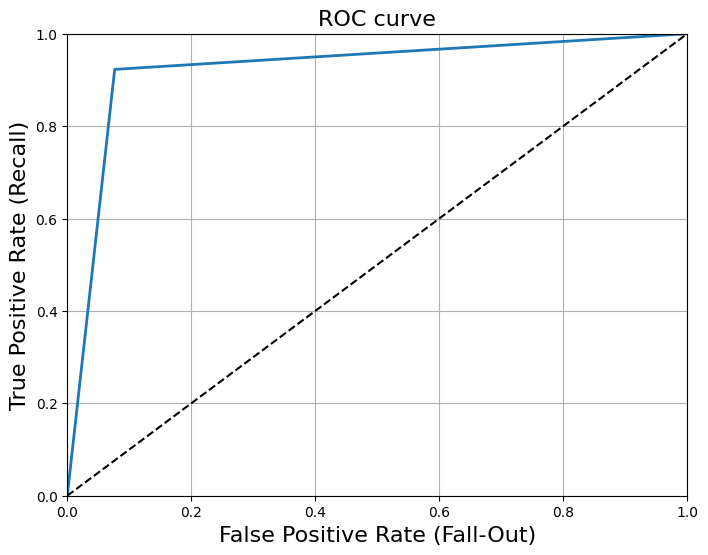

In [13]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title("ROC curve", fontsize=16)
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()


In [14]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_train_pred)

0.9231682146542829

## Diabetes Dataset

In [15]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [16]:
cols = ["Pregnancies" ,"Glucose" ,"BloodPressure" ,"SkinThickness" ,"Insulin" ,"BMI" ,"DiabetesPedigreeFunction" ,"Age" ,"Outcome"]
url = "https://gist.githubusercontent.com/ktisha/c21e73a1bd1700294ef790c56c8aec1f/raw/819b69b5736821ccee93d05b51de0510bea00294/pima-indians-diabetes.csv"

diabetes_data = pd.read_csv(url, skiprows=9, header=None, names=cols)
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [17]:
diabetes_data.shape


(768, 9)

In [18]:
# X = diabetes_data[['Glucose','BMI']]
X = diabetes_data[cols[:-1]]
y = diabetes_data[cols[-1]]

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, stratify=y, random_state=42)


y_train = y_train.values
y_test = y_test.values

In [19]:
# from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

dec_clf = DecisionTree(max_depth=12)

# cv_results = cross_validate(dec_clf, X_train, y_train, cv=2, scoring='accuracy', return_estimator=True)
# clf = cv_results["estimator"][1]


scores =  cross_val_score(dec_clf, X_train, y_train, cv=2, scoring='accuracy')

In [20]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [21]:
display_scores(scores)


Scores: [0.6734104  0.71884058]
Mean: 0.6961254921672112
Standard deviation: 0.02271508754293372


In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(dec_clf, X_train, y_train, cv=2)

## Confusion matrix


In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, y_train_pred)
print(cm)

[[339 111]
 [105 136]]


## Precision, Recall, F1-score


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(y_train, y_train_pred)


0.5506072874493927

In [25]:
recall_score(y_train, y_train_pred)


0.5643153526970954

In [26]:
f1_score(y_train, y_train_pred)


0.5573770491803278

## ROC Curve

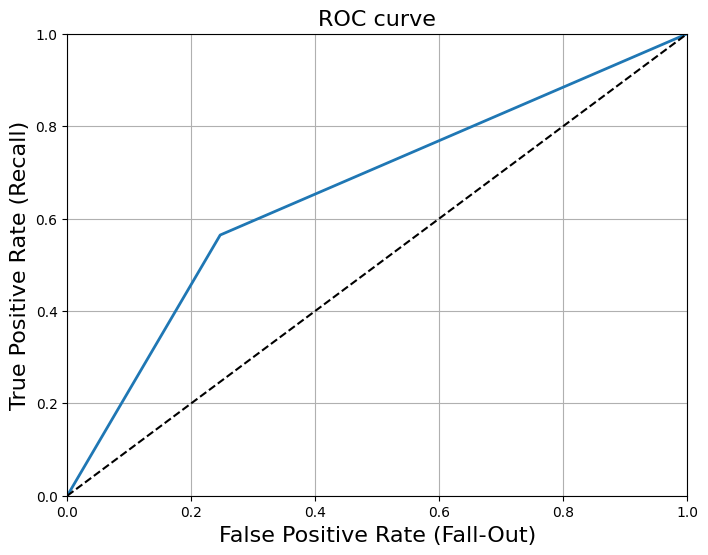

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_train, y_train_pred)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title("ROC curve", fontsize=16)
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_train_pred)

0.6588243430152144

## Prediction

In [29]:
clf = DecisionTree(max_depth=14)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)
print ("Accuracy:", acc)

Accuracy: 0.7662337662337663
